# Job Recommendation for Stack Overflow users

## Goal 
Stack Overflow users can be ranked based on the number of questions they answer and the cumulative scores for all their answers. The goal is to recommend jobs for a specific user by building a profile strength for that user. The profile strength for a user can be determined using characteristics of users such as their skills, answers they gave and user "About Me" information.




## Data Sources/Collection and Description

There are two main datasets used in this project. 
#### 1. The Users dataset
The Users dataset is a combination of several datasets obtained from the Stack Overflow data dump. This dataset consists of Questions, Answers, associated scores and tags for each answer, user reputation and "About Me" information for each user. To understand how many answers were given by each user, I constructed a feature to count the number of answers given per user. All the questions and answers are based on computer science and programming.  

The Stack Overflow data dump can be found at:
* https://archive.org/details/stackexchange

#### 2. The Job description dataset

The Job descriptions dataset was scrapped from online job boards. The goal was to retrieve all jobs related to Data science and Software Engineering. The following keywords were used in the search of all related job postings:
1. Data scientist
2. Data Engineer
3. Data Analyst
4. Data science
5. Machine learning
6. Business Analyst
7. Software engineer
8. Fullstack developer
9. Frontend developer
10. Backend developer

The locations used for the search:
1. San Francisco, CA
2. Mountain View, CA
3. Seattle, WA
4. New York, NY
5. Los Angeles, CA

The goal of scrapping the job boards was to obtain a detailed job description which comprised of all the skills required for that job. I used Scrapy to write a web crawler to recursively parse through all the job posting links for a given search parameter and location. 

The intial problem I encountered with scrapping the job board was the inconsistency in the structure of the job descriptions. Some job posting links were hosted by the job board whereas some links redirected to an external website. To overcome this problem, I parsed through each of the links to obtain the entire html code for that particular job description. This enabled me to grab all the required information related to job description even if it was redirected to an external website. 

## Data Munging and Cleaning

### 1. Users Dataset

The Users dataset is an amalgamation of the following datasets: 
 1. Questions dataset : This dataset consists of all the Questions related to computer science and programming.
 2. Answers dataset : This dataset consists of all Answers related to the respecitve questions.
 3. Users master dataset : This dataset consists of all users and their profile information.
 4. Tags dataset : The tags dataset consists of all tags associated with a particular question. Each question on Stack Overflow is tagged with certain keywords.
 
    ##### For example : " How can I concatenate two pandas dataframes?" 
    ##### The tags associated with this question would be "pandas","python" 
    

In [103]:
## Loading Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from bs4 import BeautifulSoup
import re
import nltk, pprint
from nltk import word_tokenize
from gensim import corpora,models,similarities
from nltk.corpus import stopwords
import joblib
from sklearn.decomposition import PCA
from sklearn import cluster, metrics
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.metrics.pairwise import cosine_similarity
import pylab
from scipy import cluster
from wordcloud import WordCloud

%config InlineBackend.figure_format = 'retina'
%config InlineBackend.figure_formats = ['svg']
sns.set(style='whitegrid', context='notebook')

In [2]:
#Load Users data set :
users = pd.read_csv('users_profile.csv')

In [5]:
#Rename columns
users.rename(columns = {'Id_y_y': 'Answer_count','Body_y':'Answer_body','Score_y':'Answer_score','CreationDate_y':
                       'Answer_CreationDate','OwnerUserId_y':'Answer_OwnerId','Id_y_x':'Answer_id','Body_x':
                       'Question_body','Score_x':'Question_score','CreationDate_x':'Question_CreationDate',
                       'OwnerUserId_x':'Question_OwnerId','Id_x':'Question_id'},inplace=True)


In [20]:
#Drop unwanted column
users.drop(['Unnamed: 0','EmailHash'],axis=1,inplace=True)

In [21]:
#Snapshot of users data
users.head()

Question_id  Question_OwnerId Question_CreationDate  ParentId  \
0           92              61.0  2008-08-01T14:45:37Z        90   
1         2973              92.0  2008-08-06T00:00:22Z      2970   
2         2976             204.0  2008-08-06T00:16:07Z      2970   
3         2978             419.0  2008-08-06T00:24:23Z      2970   
4         3055             116.0  2008-08-06T03:31:22Z      2970   

   Question_score                                      Question_body  \
0              13  <p><a href="http://svnbook.red-bean.com/">Vers...   
1               3  <p>With a six word character password, he may ...   
2              13  <p>Try and gather as much information as you c...   
3               2  <P>Is the site just plain static HTML? i.e. he...   
4               5  <p>You mention your Dad was using a website pu...   

   Answer_id  Answer_OwnerId   Answer_CreationDate            ClosedDate  \
0         90            58.0  2008-08-01T14:41:24Z  2012-12-26T03:45:49Z   
1       2970            58.0  2008-08-05T23:55:25Z  2012-03-06T03:17:01Z   
2       2970            58.0  2008-08-05T23:55:25Z  2012-03-06T03:17:01Z   
3       2970            58.0  2008-08-05T23:55:25Z  2012-03-06T03:17:01Z   
4       2970            58.0  2008-08-05T23:55:25Z  2012-03-06T03:17:01Z   

       ...               Location   Views  \
0      ...       Indianapolis, IN  1278.0   
1      ...       Indianapolis, IN  1278.0   
2      ...       Indianapolis, IN  1278.0   
3      ...       Indianapolis, IN  1278.0   
4      ...       Indianapolis, IN  1278.0   

                                             AboutMe           LastAccessDate  \
0  <p>Front-End Engineer at Exact Target</p>\n\n<...  2016-08-26T14:17:54.537   
1  <p>Front-End Engineer at Exact Target</p>\n\n<...  2016-08-26T14:17:54.537   
2  <p>Front-End Engineer at Exact Target</p>\n\n<...  2016-08-26T14:17:54.537   
3  <p>Front-End Engineer at Exact Target</p>\n\n<...  2016-08-26T14:17:54.537   
4  <p>Front-End Engineer at Exact Target</p>\n\n<...  2016-08-26T14:17:54.537   

   ProfileImageUrl UpVotes             CreationDate User_Id  AccountId  \
0              NaN   957.0  2008-08-01T13:56:33.807    58.0       47.0   
1              NaN   957.0  2008-08-01T13:56:33.807    58.0       47.0   
2              NaN   957.0  2008-08-01T13:56:33.807    58.0       47.0   
3              NaN   957.0  2008-08-01T13:56:33.807    58.0       47.0   
4              NaN   957.0  2008-08-01T13:56:33.807    58.0       47.0   

   Answer_count  
0            22  
1            22  
2            22  
3            22  
4            22  

[5 rows x 30 columns]

In [23]:
users.shape

(1982623, 30)

There are some users with 'None'as a description about themselves in the "About Me" column and some with NaN values. 
The idea is to select only the users with "About Me" information, so that this information can aid in building the profile of user.

In [6]:
#Filter out users with "About Me" description and with Nan values
users_aboutme = users[users['AboutMe'] != 'None']
users_aboutme = users_aboutme[pd.notnull(users_aboutme['AboutMe'])]

In [ ]:
#Descriptive stats on users_aboutme 
users_aboutme.describe()

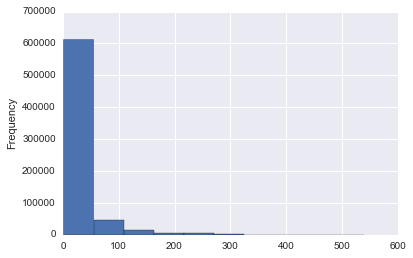

In [8]:
#Looking at distribution of Answer count per user
users_aboutme.Answer_count.plot(kind='hist')

In [14]:
#Pick threshold for Answer count -> 10 answers per user
users_profile = users_aboutme[users_aboutme['Answer_count'] > 7]

In [2]:
#Writing to csv file
#users_profile.to_csv('users_profile_final.csv')
users_profile = pd.read_csv('users_profile_final.csv')

##### Cleaning the Text columns with html tags -> AboutMe, Answers_body and Questions_body
Using BeautifulSoup to get only text from these columns

In [57]:
# Function to convert a raw html to a string of words
    # The input is a single string (a raw html), and 
    # the output is a single string (preprocessed text)

def html_to_words( raw_html ):
    
    # 1. Remove HTML
    job_text = BeautifulSoup(raw_html,"html.parser")
    #soup = BeautifulSoup(html)
    job_text = ''.join(job_text.findAll(text=True))

    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z0-9#+]", " ", job_text) 
    #letters_only = review_text.replace("\n","")
    
    #
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split() 
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]  
    #
    
    # 4. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join(meaningful_words))   


In [27]:
#Before cleaning the "About Me"
users_profile['About_me'][0]

array([ u'Front-End Engineer at Exact Target\nCo-Author of HTML, XHTML and CSS All-in-one Desk Reference for Dummies\nGraduated from IU with a Bachelors of Media Arts and Science and a Certificate in Applied Computer Science.\nTech Editor for Building Facebook Applications for Dummies and Building Websites All-in-one for Dummies 2nd Edition.\nCreator and maintainer of the Status-bar Calculator Firefox and Chrome extensions\nThree years professional experience in Java E-Commerce Development and four years professional experience with PHP\nTeach Server Side Programming with PHP and Mobile Applications Development at IUPUI\n',
       u'a long time ago i found an xss vuln here and took down the entire site\nuserid 26, respect\n',
       u"Full-Stack Developer at Stack Overflow, working to make our little corner of the Internet better for all of us.\nIf it consumes electricity, chances are good that I worked with it or at least know about it. Graduated as SysAdmin, turned Programmer. C# (AS

In [ ]:
users_profile['AboutMe'] = users_profile.AboutMe.apply(html_to_words)

In [33]:
users_profile['About_me'].tail(20)

1968292                                     i'm a developer.
1968293                                     i'm a developer.
1968294                                     i'm a developer.
1968295                                     i'm a developer.
1968296                                     i'm a developer.
1968297                                     i'm a developer.
1968298                                     i'm a developer.
1968299                                     i'm a developer.
1968300                                     i'm a developer.
1976454    ui developer with 9 years of experience and kn...
1976455    ui developer with 9 years of experience and kn...
1976456    ui developer with 9 years of experience and kn...
1976457    ui developer with 9 years of experience and kn...
1976458    ui developer with 9 years of experience and kn...
1976459    ui developer with 9 years of experience and kn...
1976460    ui developer with 9 years of experience and kn...
1976461    ui developer 

In [3]:
#Load final cleaned users data set
users_cleaned_copy = pd.read_csv("users_cleaned_copy.csv")

/Users/varshapullabhotla/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### 2. Job Description Data

Job Descriptions dataset contains job descriptions in text, company name, title of the job, location

In [3]:
job_descriptions = pd.read_csv("jobs_final.csv")

In [4]:
job_descriptions.drop('Unnamed: 0',axis=1,inplace=True)

In [46]:
job_descriptions.head()

node  J2EE  nosql  JavaScript  Redis  dl  RabbitMQ  kafka  linux  hbase  \
0     0     0      0           0      0   0         0      0      0      0   
1     0     0      0           0      0   0         0      0      0      0   
2     0     0      0           1      0   0         0      0      0      0   
3     0     0      0           0      0   0         0      0      0      0   
4     0     0      0           0      0   0         0      0      0      0   

                     ...                     tensorflow  \
0                    ...                            0.0   
1                    ...                            0.0   
2                    ...                            0.0   
3                    ...                            0.0   
4                    ...                            0.0   

                                                 url   ml  seaborn  mapreduce  \
0  http://www.indeed.com/rc/clk?jk=aebef464939367...  0.0      0.0        0.0   
1  http://www.indeed.com/rc/clk?jk=a823e56fe208ab...  0.0      0.0        0.0   
2  http://www.indeed.com/rc/clk?jk=982a10d921a082...  0.0      0.0        0.0   
3  http://www.indeed.com/rc/clk?jk=dcdbb79f9a3dca...  0.0      0.0        0.0   
4  http://www.indeed.com/rc/clk?jk=f2d716747daeb7...  0.0      0.0        0.0   

   hive                                            summary  Csharp  spark  \
0   0.0   \n\n\n\n\n\n\n\n    <a href="http://www.grail...     0.0    0.0   
1   0.0  \r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r...     0.0    0.0   
2   0.0  <!DOCTYPE html>\r\n<html lang="en">\r\n\t<head...     0.0    0.0   
3   1.0  <!DOCTYPE html><html><head><!--[if IE]>\n<meta...     0.0    0.0   
4   0.0  \n\n\n    <!doctype html>\n    <!--[if lt IE 7...     0.0    0.0   

                                      title  
0                   DATA ANALYSIS SCIENTIST  
1                         Data Analyst - Jr  
2  Data Scientist/Machine Learning Engineer  
3                           Product Analyst  
4                         Marketing Analyst  

[5 rows x 49 columns]

In [48]:
#Cleaning Job description text -> summary

#Function to clean html tags, javascript tags to return only text from scraped html page

def job_text_cleaner(job):
    soup = BeautifulSoup(job,'html.parser')
    for script in soup(["script", "style","noscript"]):
        script.decompose()    # Remove javascript based tags
    text = soup.get_text()    # Get all text only
    lines = (line.strip() for line in text.splitlines())
    # break multi-headlines into a line each
    chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
    # drop blank lines
    text = '\n'.join(chunk for chunk in chunks if chunk)
    txt = re.sub("[^a-zA-Z0-9#+]", " ", text) #Remove any unnecessary characters other than a-z , A-Z , 0-9 , + , #
    txt = txt.lower() # transform to lowercase 
    return txt



In [ ]:
jobs.summary = jobs.summary.apply(job_text_cleaner)

In [25]:
#Loading final cleaned job dataset
jobs = pd.read_csv('jobs_cleaned.csv')
jobs.rename(columns={'Unnamed: 0':'jobId'},inplace=True)


In [64]:
jobs.head()

jobId  Unnamed: 0.1  node  J2EE  nosql  JavaScript  Redis  dl  RabbitMQ  \
0      0             0     0     0      0           0      0   0         0   
1      1             1     0     0      0           0      0   0         0   
2      2             2     0     0      0           1      0   0         0   
3      3             3     0     0      0           0      0   0         0   
4      4             4     0     0      0           0      0   0         0   

   kafka                        ...                          \
0      0                        ...                           
1      0                        ...                           
2      0                        ...                           
3      0                        ...                           
4      0                        ...                           

                                                 url   ml  seaborn  mapreduce  \
0  http://www.indeed.com/rc/clk?jk=aebef464939367...  0.0      0.0        0.0   
1  http://www.indeed.com/rc/clk?jk=a823e56fe208ab...  0.0      0.0        0.0   
2  http://www.indeed.com/rc/clk?jk=982a10d921a082...  0.0      0.0        0.0   
3  http://www.indeed.com/rc/clk?jk=dcdbb79f9a3dca...  0.0      0.0        0.0   
4  http://www.indeed.com/rc/clk?jk=f2d716747daeb7...  0.0      0.0        0.0   

   hive                                            summary  Csharp  spark  \
0   0.0  position  data analysis scientist location  sa...     0.0    0.0   
1   0.0  fieldglass  fcp search register sign in go to ...     0.0    0.0   
2   0.0  irhythm job   details   irhythm technologies x...     0.0    0.0   
3   1.0  square product analyst   smartrecruiters produ...     0.0    0.0   
4   0.0  marketing analyst   marketing   san francisco ...     0.0    0.0   

                                      title  \
0                   DATA ANALYSIS SCIENTIST   
1                         Data Analyst - Jr   
2  Data Scientist/Machine Learning Engineer   
3                           Product Analyst   
4                         Marketing Analyst   

                                              skills  
0  ['python', 'data analysis', 'java', 'excel', '...  
1                 ['statistic', 'excel', 'database']  
2                                           ['test']  
3      ['sql', 'database', 'git', 'hive', 'tableau']  
4  ['data mining', 'python', 'data analysis', 'st...  

[5 rows x 52 columns]

## Exploratory Data Analysis

### Whats is the distribution of questions asked over the years?

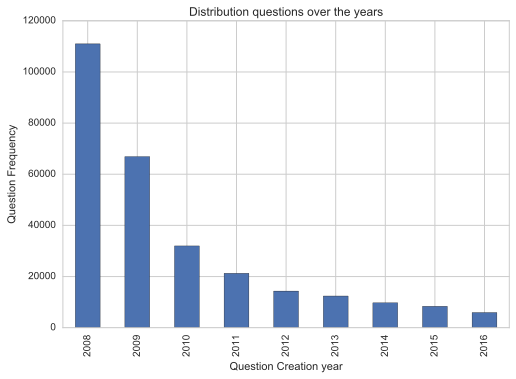

In [40]:
ax = users_cleaned_copy.groupby(['Q_year'])['Question_id'].count().plot(kind='bar')
#fig, ax = plt.subplots(figsize=(8,6))
#ax.plot(closed.groupby(['Q_year'])['ClosedDate'].count())
ax.set_title('Distribution questions over the years')
ax.set_xlabel('Question Creation year')
ax.set_ylabel('Question Frequency')
plt.savefig('ques_dist.pdf')

###### Comments : We see that the dataset contains a majority of questions created in 2008. 

### What is the distribution of the questions that have been categorized as "Closed"? 
Questions are categorized as "Closed" when there is an accepted answer for the question asked. Looking at the graph we see a huge number of questions in 2008 as compared to the other years. This is because the volume of questions in 2008 are the highest in terms of both closed and open in general. 

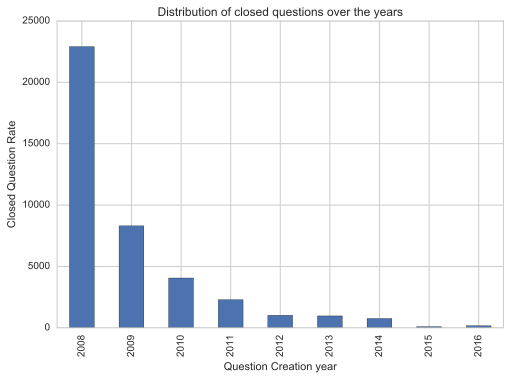

In [41]:
# Distribution of closed questions over the years
closed = users_cleaned_copy[users_cleaned_copy['ClosedDate'].notnull()]

ax = closed.groupby(['Q_year'])['ClosedDate'].count().plot(kind='bar')
#fig, ax = plt.subplots(figsize=(8,6))
#ax.plot(closed.groupby(['Q_year'])['ClosedDate'].count())
ax.set_title('Distribution of closed questions over the years')
ax.set_xlabel('Question Creation year')
ax.set_ylabel('Closed Question Rate')
plt.savefig('closed_ques_dist.pdf')

In [8]:
users_cleaned_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281712 entries, 0 to 281711
Data columns (total 36 columns):
Unnamed: 0               281712 non-null int64
Unnamed: 0.1             281712 non-null int64
Question_id              281712 non-null int64
Question_OwnerId         273934 non-null float64
Question_CreationDate    281712 non-null object
ParentId                 281712 non-null int64
Question_score           281712 non-null int64
Question_body            281628 non-null object
Answer_id                281712 non-null int64
Answer_OwnerId           281712 non-null float64
Answer_CreationDate      281712 non-null object
ClosedDate               40585 non-null object
Answer_score             281712 non-null int64
Title                    281712 non-null object
Answer_body              281712 non-null object
tags                     281712 non-null object
DownVotes                281712 non-null float64
DisplayName              281712 non-null object
Age                      25205

### What is the distribution of Question Scores? 

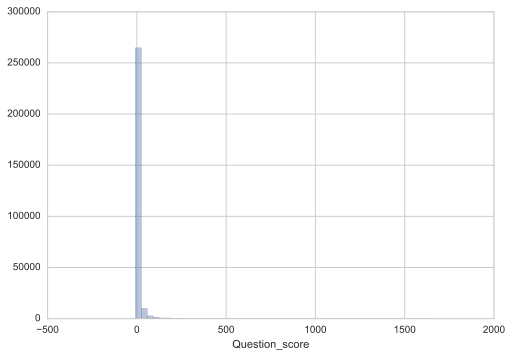

In [54]:
#Question Score distribution

#fig = users_cleaned_copy.groupby(['Q_year'])['Question_score'].sum().plot(kind='hist')
sns.distplot(users_cleaned_copy.Question_score,kde=False)
fig.set_title('Distribution of Scores for Questions')
fig.set_xlabel('Question Creation year')
fig.set_ylabel('Cumulative sum of Score per year')
plt.savefig('ques_scores_dist.pdf')


### What is the distribution of Answer Scores? 

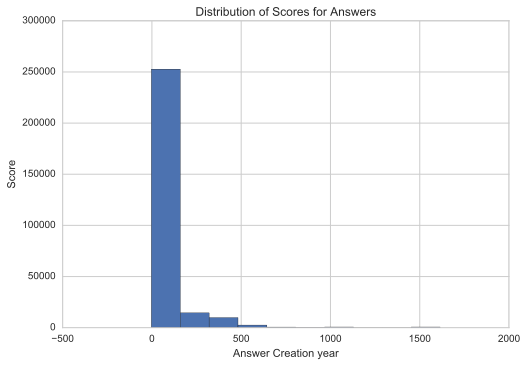

In [56]:
#Answer score distribution 
fig = users_cleaned_copy.Answer_score.plot(kind='hist')
fig.set_title('Distribution of Scores for Answers')
fig.set_xlabel('Answer Creation year')
fig.set_ylabel('Score')
plt.savefig('ans_scores_dist.pdf')

### Trending Skills over the years

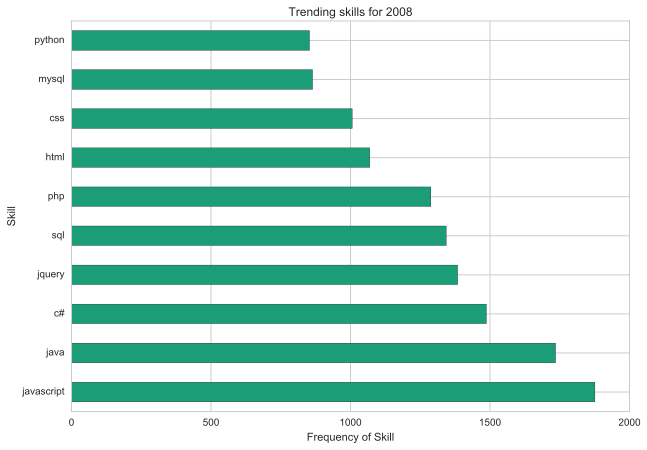

In [13]:
#Trending skills for 2008
u2008 = users_cleaned_copy[users_cleaned_copy.Q_year == 2008]
plt.figure(figsize=(10,7))
fig = u2008.skill.value_counts().head(10).plot(kind='barh',cmap=plt.cm.Dark2)
fig.set_xlabel("Frequency of Skill")
fig.set_ylabel("Skill")
fig.set_title("Trending skills for 2008")
plt.savefig("trending_skill2008.pdf")


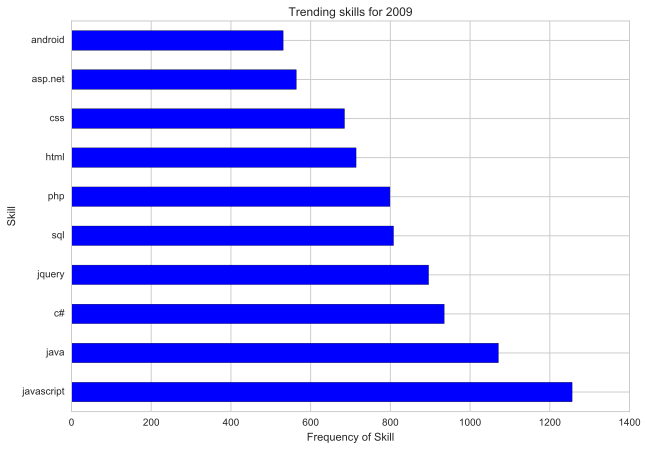

In [14]:
#Trending skills for 2009
u2009 = users_cleaned_copy[users_cleaned_copy.Q_year == 2009]
plt.figure(figsize=(10,7))
fig1 = u2009.skill.value_counts().head(10).plot(kind='barh',cmap='winter')
fig1.set_xlabel("Frequency of Skill")
fig1.set_ylabel("Skill")
fig1.set_title("Trending skills for 2009")
plt.savefig("trending_skill2009.pdf")

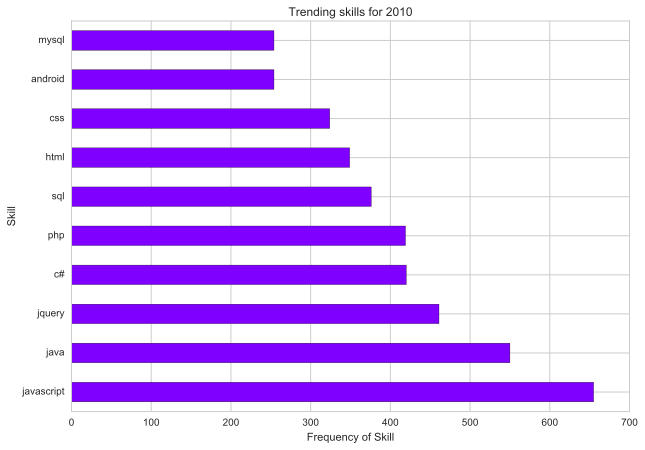

In [16]:
#Trending skills for 2010
u2010 = users_cleaned_copy[users_cleaned_copy.Q_year == 2010]
plt.figure(figsize=(10,7))
fig = u2010.skill.value_counts().head(10).plot(kind='barh',cmap='rainbow')
fig.set_xlabel("Frequency of Skill")
fig.set_ylabel("Skill")
fig.set_title("Trending skills for 2010")
plt.savefig("trending_skill2010.pdf")


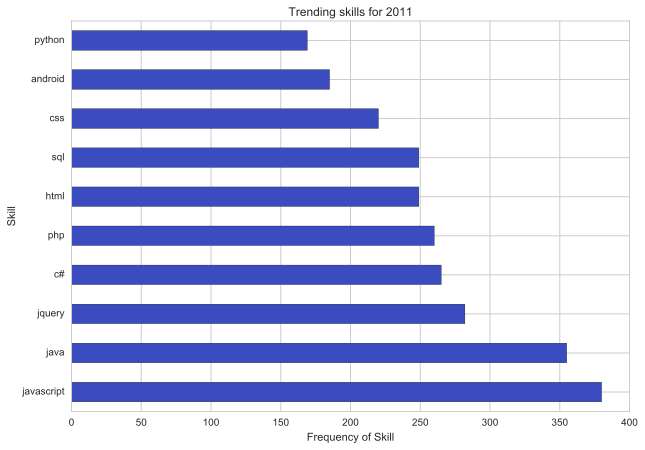

In [17]:
#Trends for skills in 2011
u2011 = users_cleaned_copy[users_cleaned_copy.Q_year == 2011]
plt.figure(figsize=(10,7))
my_colors = 'rgbkymc'
fig = u2011.skill.value_counts().head(10).plot(kind='barh',cmap='coolwarm')
fig.set_xlabel("Frequency of Skill")
fig.set_ylabel("Skill")
fig.set_title("Trending skills for 2011")
plt.savefig("trending_skill2011.pdf")


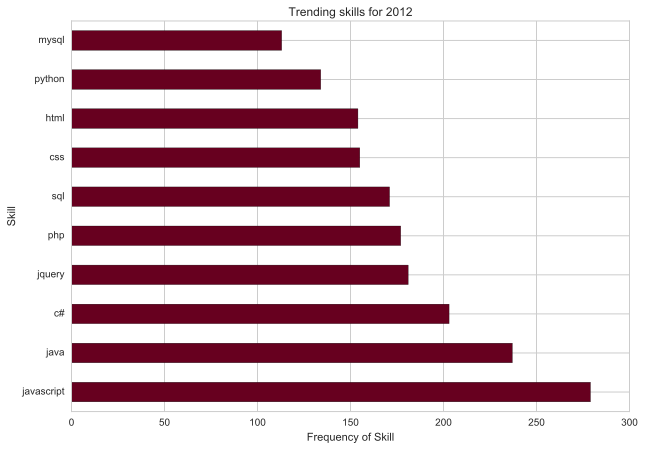

In [18]:
#Trends in skills for 2012
u2012 = users_cleaned_copy[users_cleaned_copy.Q_year == 2012]
plt.figure(figsize=(10,7))
fig = u2012.skill.value_counts().head(10).plot(kind='barh',cmap=plt.cm.RdBu)
fig.set_xlabel("Frequency of Skill")
fig.set_ylabel("Skill")
fig.set_title("Trending skills for 2012")
plt.savefig("trending_skill2012.pdf")

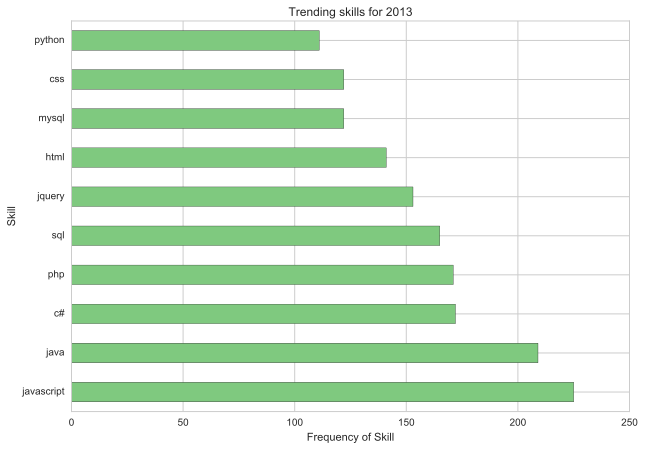

In [19]:
#Trends of skils for 2013
u2013 = users_cleaned_copy[users_cleaned_copy.Q_year == 2013]
plt.figure(figsize=(10,7))
fig = u2013.skill.value_counts().head(10).plot(kind='barh',cmap=plt.cm.Accent)
fig.set_xlabel("Frequency of Skill")
fig.set_ylabel("Skill")
fig.set_title("Trending skills for 2013")
plt.savefig("trending_skill2013.pdf")


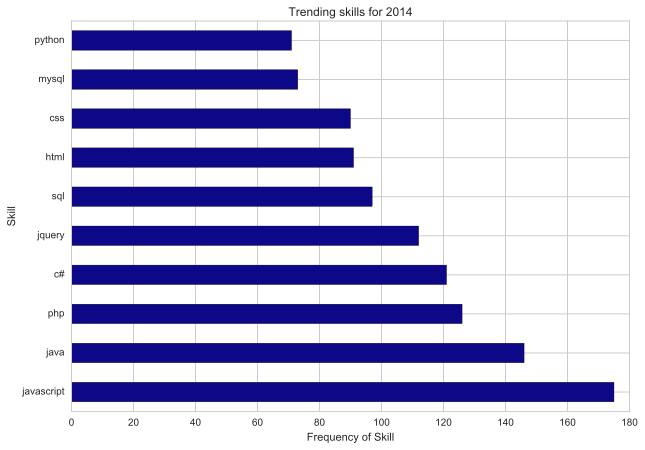

In [20]:
#Trends in skills for 2014
u2014 = users_cleaned_copy[users_cleaned_copy.Q_year == 2014]
plt.figure(figsize=(10,7))
fig = u2014.skill.value_counts().head(10).plot(kind='barh',cmap = plt.cm.plasma)
fig.set_xlabel("Frequency of Skill")
fig.set_ylabel("Skill")
fig.set_title("Trending skills for 2014")
plt.savefig("trending_skill2014.pdf")

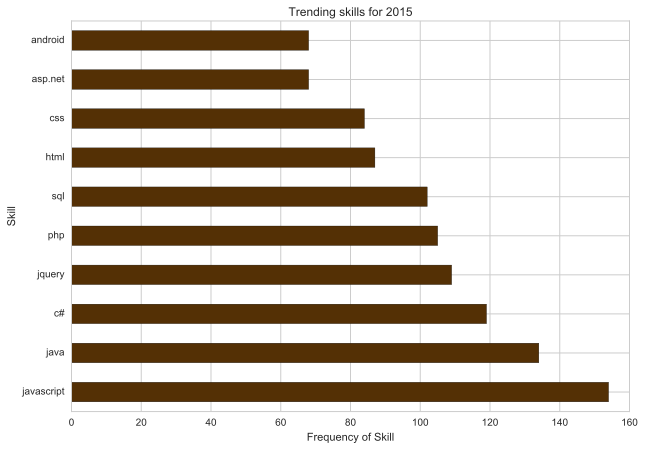

In [21]:
#Trends in skills for 2015
u2015 = users_cleaned_copy[users_cleaned_copy.Q_year == 2015]
plt.figure(figsize=(10,7))
fig = u2015.skill.value_counts().head(10).plot(kind='barh',cmap = plt.cm.BrBG)
fig.set_xlabel("Frequency of Skill")
fig.set_ylabel("Skill")
fig.set_title("Trending skills for 2015")
plt.savefig("trending_skill2015.pdf")


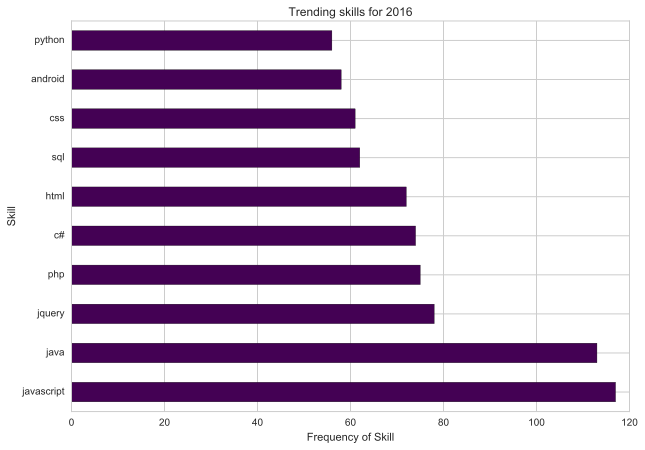

In [22]:
#Trends in skills for 2016
u2016 = users_cleaned_copy[users_cleaned_copy.Q_year == 2016]
plt.figure(figsize=(10,7))
fig = u2016.skill.value_counts().head(10).plot(kind='barh',cmap=plt.cm.viridis)
fig.set_xlabel("Frequency of Skill")
fig.set_ylabel("Skill")
fig.set_title("Trending skills for 2016")
plt.savefig("trending_skill2016.pdf")

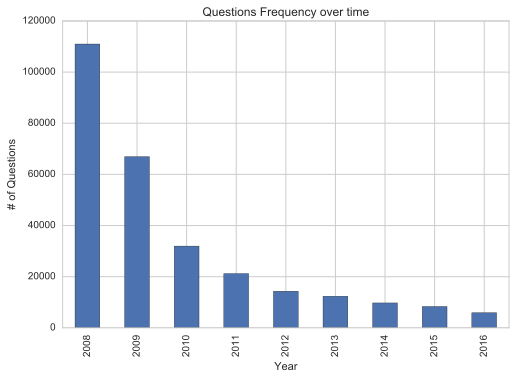

In [23]:
#Number of questions both closed and open over the years
fig = users_cleaned_copy.groupby(['Q_year'])['Question_id'].count().plot(kind='bar')
plt.figure(figsize=(10,7))

fig.set_xlabel("Year")
fig.set_ylabel("# of Questions")
fig.set_title("Questions Frequency over time")
plt.savefig("question_freq.pdf")

### How is Python trending? 

281712


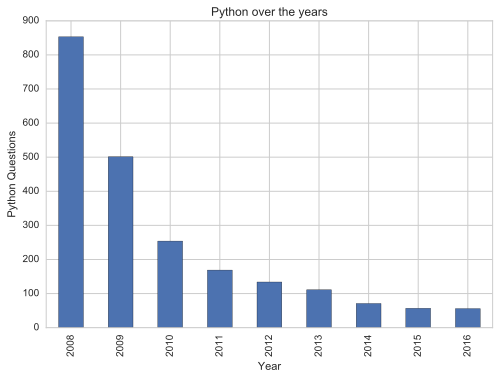

In [24]:
#Looking at Python trends over the years
python_trend = users_cleaned_copy[users_cleaned_copy.skill == 'python']

print len(users_cleaned_copy.skill) 
len(users_cleaned_copy[users_cleaned_copy.skill == 'python'])# / len(users_cleaned_copy.skill) 
2206.0/281712.0 * 100

fig = python_trend.groupby(['Q_year'])['skill'].count().plot(kind='bar')
plt.figure(figsize=(10,7))

fig.set_xlabel("Year")
fig.set_ylabel("Python Questions")
fig.set_title("Python over the years")
plt.savefig("python_trend.pdf")

Comments : The number of questions in 2008 are the highest, so it's not surprising that 2008 contains the most number of python questions. However on average : only 0.78% of the questions asked are related to python.

### What are employers looking for in Data Science candidates?

In [26]:
#Create a Data science job dataframe
job = jobs.copy()
job.title.fillna("None",inplace=True)
ds_jobs = jobs[job.title.str.contains("Data") | job.title.str.contains("Machine")]

ds_jobs.skills = ds_jobs.skills.apply(lambda x: x.split(","))

ds_jobs.skills = ds_jobs.skills.apply(lambda x: [y.replace("[","").replace("]","").replace("'","").strip(" ") for y in x])

ds_jobs.skills = ds_jobs.skills.apply(lambda x: list(set(x)))

ds_skill = ds_jobs.apply(lambda x: pd.Series(x['skills']),axis=1).stack().reset_index(level=1, drop=True)

ds_skill = ds_skill.reset_index()
ds_skill.columns = ['jobId','skill']


ds_jobs= pd.merge(job,ds_skill,left_on='jobId',right_on='jobId')

/Users/varshapullabhotla/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2701: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


### The Top 30 skills listed in Data Science Job Descriptions

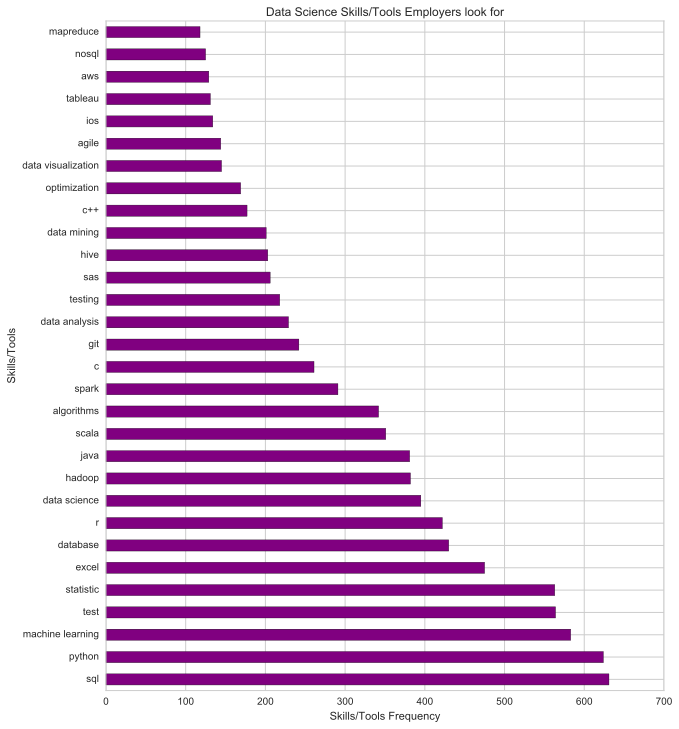

In [27]:
plt.figure(figsize=(10,12))

fig = ds_jobs.skill.value_counts().head(30).plot(kind='barh',color='purple')

fig.set_xlabel("Skills/Tools Frequency")
fig.set_ylabel("Skills/Tools")
fig.set_title("Data Science Skills/Tools Employers look for")
plt.savefig("ds_jobskills.pdf")

Comments : Make sure you're a SQL Expert!

In [29]:
#Top Data science skills in all job postings
ds_jobs.skill.value_counts().nlargest(20)

sql                 631
python              624
machine learning    583
test                564
statistic           563
excel               475
database            430
r                   422
data science        395
hadoop              382
java                381
scala               351
algorithms          342
spark               291
c                   261
git                 242
data analysis       229
testing             218
sas                 206
hive                203
Name: skill, dtype: int64

### Stack Overflow Users Reputation Distribution

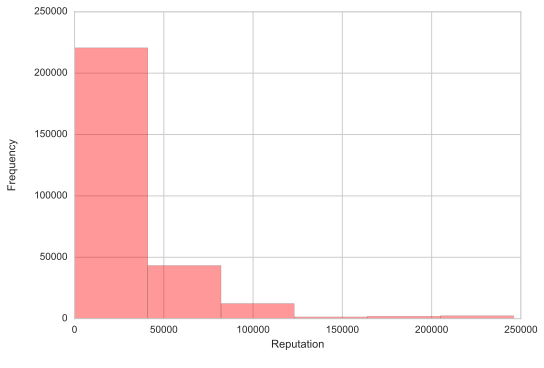

In [35]:
rep_dist = sns.distplot(users_cleaned_copy.Reputation,kde=False,color='Red',bins=6)
plt.figure(figsize=(10,7))
rep_dist.set_xlabel("Reputation\n")
rep_dist.set_ylabel("Frequency\n")
fig.savefig('user_reputation_distribution.pdf') 
plt.show()

## Feature Engineering

## 1. Skills extraction for Stack Overflow Users
The questions asked on Stack Overflow have tags associated with them. The assumption made here is that these tags help understand User skills. When a user answers a specific question, it is assumed that they have some proficiency in that subject matter. 

- But how do we judge the User? i.e How do we know for sure that is User has some knowledge about the concept?
      - This is where User's Reputation and Answer count comes in. We filter users above a certain Answer count threshold.
  
  __Since Answer count and Reputation are correlated with Upvotes for an answer, we know that the User's Reputation validates their proficiency.__
  
- The threshold that is set to filter the Users is an Answer count greater than 7 

### 1.1 Skill Vocabulary List 
This vocabulary is a list of all skills related to Data science and Software engineering.

In [58]:
#Load skills vocabulary 
skills = joblib.load('skills_list.pkl')

In [61]:
skills[1:20]

['machine learning ',
 'python',
 'data analysis',
 'statistic',
 'sql',
 'java',
 'matlab',
 'algorithms',
 'linux',
 'excel',
 'ruby',
 'test',
 'database',
 'c++',
 'hadoop',
 'sas',
 'javascript',
 'nlp',
 'image processing']

In [62]:
#Load cleaned data set for user skill extraction
users_data = pd.read_csv("users_data.csv")

In [ ]:
#Function to create a list of skills for each user

def findWholeWord(w):
    return re.compile(r'\b({0})\b'.format(w), flags=re.IGNORECASE).search

def skill_extraction(text):
    slist = []
    for skill in skills:
        if skill in text:
            slist.append(skill)
    if findWholeWord('c')(text):
        slist.append('c')
    if findWholeWord('r')(text):
        slist.append('r')
    if findWholeWord('ui')(text):
        slist.append('ui')
    if findWholeWord('aws')(text):
        slist.append('aws')
    
    return slist

We apply the skill extraction function to "AboutMe" column of the users since some of them contain skills of the user.

In [ ]:
#Skills from users aboutme
users_data['aboutme_skills'] =users_data['AboutMe'].apply(skill_extraction)

### 1.2 Consolidate the skills for each User

In [ ]:
#Add aboutme_skills with tags to get final list of skills

users_data['all_skills'] = users_data['aboutme_skills'] + users_data['skill_list']

### 1.3 Create a skill vector for each User
- Step 1 : First make a list of all skills that are present in the Skills vocabulary
- Step 2: Then convert this list into a vector 

In [65]:
#Function to create a list of all skills present in the Skills vocabulary
def Revgenerate_skill_vector(text):
    ski_vec = []
    for j in skills:
        for i in text:
            if re.findall(i,j):
                skvec.append(j)
            
    return ski_vec

In [ ]:
users_data['rev_skills'] = users_data['all_skills'].apply(Revgenerate_skill_vector)

In [ ]:
Comments : Some challenges faced here:
        1. The "tags" for each question used as skills were sometimes more than one word. This made it difficult to
        match with the skills ontology. Thus tags which had more than one word were split to make sure the length of
        each word consider was 1

In [66]:
#Function to create a skill vector from the above rev_skills list for each User
def generate_skill_vector(text):
    ski_vec = []
    for skill in skills:
        if skill in text:
            ski_vec.append(1)
        else:
            ski_vec.append(0)
    return ski_vec

In [ ]:
users_data['skill_vector'] = users_data['rev_skillSet'].apply(lambda x: generate_skill_vector(x))
user_skill_matrix = np.vstack(users_data['skill_vector'])

In [67]:
#Load final user_skill_matrix
user_skill_matrix = joblib.load('user_skill_matrix.pkl')
user_skill_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 1],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

## 2. Skill Extraction for Job Descriptions

### 2.1 The skill extraction for Job descriptions involves:
- Extract all the skills from the summary of a job (Job Description) from Skill Vocabulary from before
- Create a skill vector for each Job for the corresponding skills

In [ ]:
#Load cleaned jobs dataset
jobs = pd.read_csv("jobs_cleaned.csv")

In [ ]:
#Extract skills from "Summary"
#Skill extraction from job summary
jobs['skills'] = jobs.summary.apply(skill_extraction)
#Clean skills before building vector
jobs.skills = jobs.skills.apply(lambda x: x.split(","))

jobs.skills = jobs.skills.apply(lambda x: [y.replace("[","").replace("]","").replace("'","").strip(" ") for y in x])

jobs.skills = jobs.skills.apply(lambda x: list(set(x)))

In [ ]:
#Create skill vector for each job
jobs['job_skill_vector'] = jobs['skills'].apply(lambda x: generate_skill_vector(x))

#Generating a job skill matrix
job_skill_matrix = np.vstack(jobs['job_skill_vector'])

In [72]:
#Final job skill matrix
job_skill_matrix = joblib.load('job_skill_matrix.pkl')
job_skill_matrix
job_skill_matrix.shape


(7985, 115)

# Making a Recommendation

The ultimate goal is to recommend jobs to a Stack Overflow User. In order to achieve this, two utility matrices are required. A utility matrix for a user is a mxn matrix where m represents the users and n represent a skill from our skill vocabulary. An entry aij could either be 1 or 0 indicating whether that user has that skill or not.
The users_skill_matrix we constructed in the previous section represents the User-Skill Utility matrix.

Similarly the jobs_skill_matrix represents the Job-Skill Utility matrix.



The User-Skill Utility matrix contains 21,809 users. 
The Job-Skill Utility matrix contains 7985 jobs
The Skill vocabulary contains 115 skills pertaining to both Software Engineering, Web development and Data science skills.

In order to make a recommendation, the idea is to measure similarity between a user and a job. However, since the number of users are high, one way to make this less computationally intensive, would be to cluster the users and then make a job recommendation.


### 1. SVD, Clustering and Building Utility matrix for users
    

In [73]:
#Applying PCA to the users skill matrix for dimensionality reduction

user_pca = PCA()
user_pca.fit(user_skill_matrix)
user_pcs = user_pca.transform(user_skill_matrix)
user_pcs = pd.DataFrame(user_pcs, columns=['PC'+str(i) for i in range(1,116)])



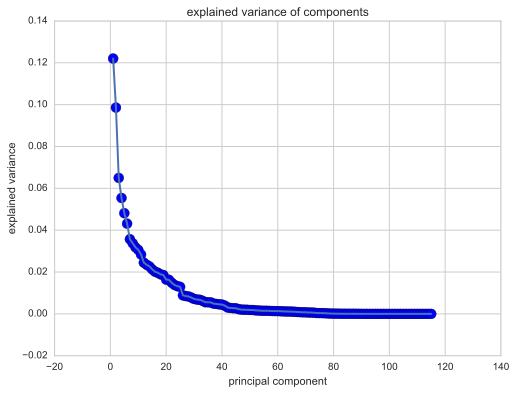

In [80]:
user_pcs = pd.DataFrame(user_pcs, columns=['PC'+str(i) for i in range(1,116)])
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(1, user_skill_matrix.shape[1]+1), user_pca.explained_variance_ratio_, lw=2)
ax.scatter(range(1, user_skill_matrix.shape[1]+1), user_pca.explained_variance_ratio_, s=100)
ax.set_title('explained variance of components')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance')
plt.show()
fig.savefig('user_principal.pdf')

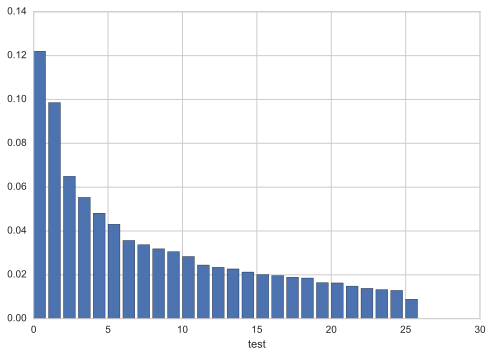

In [87]:
# fig = 
plt.bar(range(0,26),user_pca.explained_variance_ratio_[0:26])
plt.xlabel('test')


# fig.set_xlabel('principal component')
# fig.set_ylabel('explained variance')
# plt.show()
# fig.savefig('user25_principal.pdf')

In [ ]:
#Matrix for 25 user pcs to use in create_cluster() function 
user_pcs_matrix = user_pcs.iloc[:,0:25].as_matrix(columns=None)

#New data frame with user 25 principal components
users = user_pcs.iloc[:,0:25]
user_name = ['User'+ str(i) for i in range(0,21809)]
users['user_name'] = user_name

In [ ]:
users = users.reset_index()

users.rename(columns={'index':'userId'},inplace=True)

In [106]:
users_data = joblib.load('users_final_final_final.pkl')

In [90]:
#Clustering users
user_pcs_matrix = user_pcs.iloc[:,0:25].as_matrix(columns=None)


#Function 
#Input : takes user data to append cluster numbers to, user matrix with pc's , number of clusters to compute,random seed
#Output : Data frame with user data appended with which cluster each user belongs to
def create_clusters(user_data,user_matrix,num_clusters,random_state):
    kmeans = KMeans(n_clusters=num_clusters,random_state=random_state)
    kmeans.fit(user_matrix)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    sns.distplot(labels,hist=True,kde=False,color='red',axlabel='cluster number',label='Distribution of users')
    
    labels = pd.DataFrame(kmeans.labels_,columns=['cluster_num'])
    users = pd.concat([user_data,labels],axis=1)
    users = users.reset_index()
    users.rename(columns={'index':'userId'},inplace=True)
    return users
    

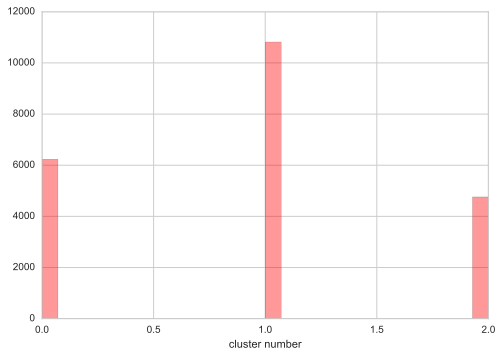

In [107]:
#Creating 3 clusters
users_clustered3 = create_clusters(users_data,user_pcs_matrix,3,0)

### Exploring these clusters
Let's take a look into how the users are naturally clustered on a high level

In [95]:
initial = [cluster.vq.kmeans2(user_pcs_matrix,i) for i in range(1,30)]

In [98]:
cent, var = initial[2]
#use vq() to get as assignment for each obs.
assignment,cdist = cluster.vq.vq(user_pcs_matrix,cent)
plt.scatter(user_pcs_matrix[:,0], user_pcs_matrix[:,1], c=assignment,cmap='RdBu')
plt.xlabel("")
plt.show()

#### We see 3 prominent clusters here and there is an overlap. 
This shows variability in the user skills but at the same time shows how a user can have many skills. Thus a user could lie on the boundary of two clusters if that person that skills which fall into both/ all clusters.

In [102]:
#Function to cross check for cluster compositions
def cluster_check(master,cluster_df,cluster_number):
    cluster = cluster_df[cluster_df.cluster_num == cluster_number]
    clu_ids = cluster.userId
    cluster_df = master[master['Unnamed: 0'].isin(clu_ids)]
    cluster_ids = cluster_df.apply(lambda x: pd.Series(x['rev_skillSet']),axis=1).stack().reset_index(level=1, drop=True)
    cluster_ids.name = 'skill'
    cluster_ids = cluster_ids.reset_index()
    cluster_ids.rename(columns={'index':'userId','sample':'skill'},inplace=True)
    clu = pd.merge(cluster_df,cluster_ids,left_on='Unnamed: 0', right_on='userId')
    
    return clu

#### High Level - With 3 Clusters

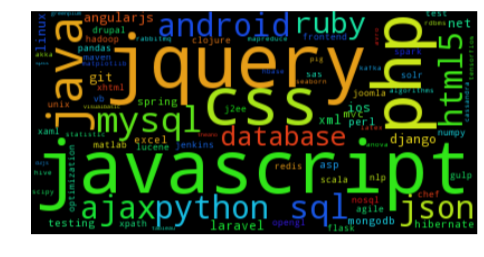

In [108]:
#Cluster 0 
u0 =users_clustered3[users_clustered3.cluster_num == 0]

clu0 = cluster_check(users_data,u0,0)

str1 = ""
for i in clu0.skill:
    str1 = str1 + " "+ i
wordcloud = WordCloud().generate(str1)
# # Open a plot of the generated image.
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

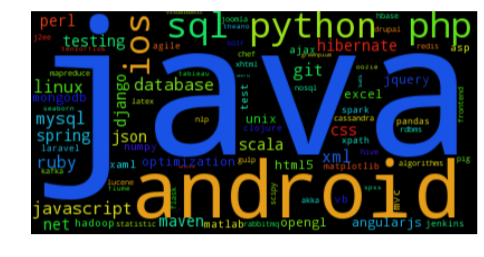

In [109]:
# Read the whole text.

u0 =users_clustered3[users_clustered3.cluster_num == 1]

clu0 = cluster_check(users_data,u0,1)

str1 = ""
for i in clu0.skill:
    str1 = str1 + " "+ i
wordcloud = WordCloud().generate(str1)
# # Open a plot of the generated image.
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

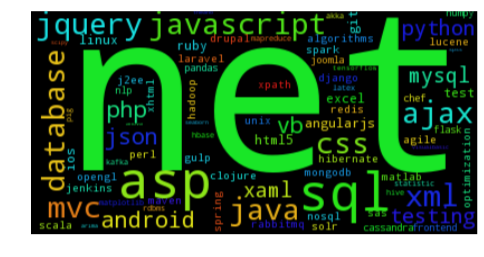

In [110]:

# Read the whole text.

u0 =users_clustered3[users_clustered3.cluster_num == 2]

clu0 = cluster_check(users_data,u0,2)

str1 = ""
for i in clu0.skill:
    str1 = str1 + " "+ i
wordcloud = WordCloud().generate(str1)
# # Open a plot of the generated image.
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

### 2. SVD and Building Utility matrix for jobs

In [111]:
#PCA on user_skill_matrix and job_skill_matrix
job_pca = PCA()
job_pca.fit(job_skill_matrix)
job_pc = job_pca.transform(job_skill_matrix)
job_pcs = pd.DataFrame(job_pc, columns=['PC'+str(i) for i in range(1,116)])


#########################################################


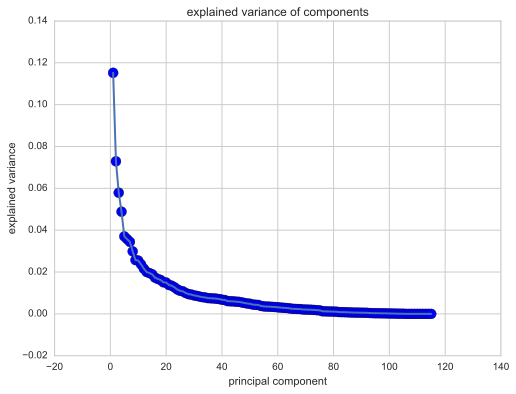

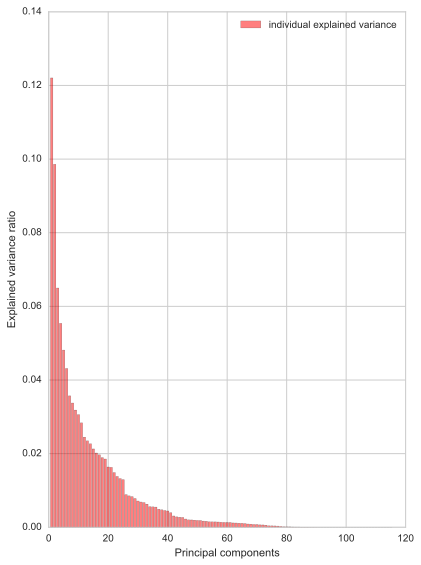

In [112]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(1, job_skill_matrix.shape[1]+1), job_pca.explained_variance_ratio_, lw=2)
ax.scatter(range(1, job_skill_matrix.shape[1]+1), job_pca.explained_variance_ratio_, s=100)
ax.set_title('explained variance of components')
ax.set_xlabel('principal component')
ax.set_ylabel('explained variance')
plt.show()
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(6, 8))

    plt.bar(range(1,116), user_pca.explained_variance_ratio_, alpha=0.5, align='center',
            label='individual explained variance',color='red')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

In [113]:
job_pcs20 = job_pcs.iloc[:,:20]

In [114]:
# #Validating clusters
# scores = []
# SSE = []
# cluster_range = [3,5,10,15,20]

# for n_clusters in cluster_range:
#     kmeans = KMeans(n_clusters=n_clusters)
#     kmeans.fit(user_pcs_matrix)

#     labels = kmeans.labels_
#     centroids = kmeans.cluster_centers_
#     inertia = kmeans.inertia_
    
#     scores.append(metrics.silhouette_score(user_pcs_matrix, labels, metric='euclidean'))
#     SSE.append(inertia.mean())

# plt.plot(scores)
# plt.ylabel("Silouette")
# plt.xlabel("k")
# plt.title("Silouette for K-means cell's behaviour")
# plt.show()


# Recommendations and Results 
A user and job are matched based on the cosine similarity of their vectors.
Both the user and job skills can be captured in 20 Principal components. These form our vectors. A cosine similarity
is computed between each user and job to get a similarity score. Based on this, another filter, in which a user and job have more than 2 skills in common are matched. 

In [117]:
users = user_pcs.iloc[:,0:20]
user_name = ['User'+ str(i) for i in range(0,21809)]
users['user_name'] = user_name
users = users.reset_index()

users.rename(columns={'index':'userId'},inplace=True)

/Users/varshapullabhotla/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [115]:
#Function to make a recommendation - Computes cosine similarity between users and jobs
#Input : Dataset with clustered users, cluster number, user principal components, job principal components, job data
#       users data, user id of user

#Output : Dataframe with a list of suitable jobs of user

def make_rec(allClusters_data,cluster_number,user_pcs,job_pcs,jobs_data,user_data,user_id):
    clusterN = allClusters_data[allClusters_data.cluster_num == cluster_number]
    clusterN_users = user_pcs[user_pcs.userId.isin(clusterN.userId)]
    clusterN_pc = clusterN_users.iloc[:,2:22]
    user_sim = cosine_similarity(clusterN_pc,job_pcs)
    user_sim_df = pd.DataFrame(user_sim)
    userSim = pd.concat([user_sim_df,clusterN_pc],axis=1)
    userSim.dropna(how='any',inplace=True)
    userSim = userSim.iloc[:,:7985]
    list_job_df = userSim.loc[user_id,:].nlargest(30).reset_index()
    userSim = userSim.reset_index()
    userSim.rename(columns={'index':'userId'},inplace=True)
    #print userSim
    list_job_df.columns= ['jobId','similarity']
    list_job_df['userId'] = user_id
    
    list_job = list_job_df['jobId'].tolist()
    
    job_user = jobs[jobs_data.jobId.isin(list_job)]
    job_user = pd.merge(job_user,list_job_df,left_on='jobId',right_on='jobId') 
    #print(job_user)
    
    job_user.sort_values('similarity',ascending=False,inplace=True)
    
    ########################################################################
    
    #Final rec dataframe
    recommendation_user1 = pd.merge(job_user,user_data,left_on='userId',right_on='Unnamed: 0')
    recommendation_user1.skills = recommendation_user1.skills.apply(lambda x: x.split(","))

    recommendation_user1.skills = recommendation_user1.skills.apply(lambda x: [y.replace("[","").replace("]","").replace("'","").strip(" ") for y in x])

    recommendation_user1.skills = recommendation_user1.skills.apply(lambda x: list(set(x)))

    recommendation_user1['common_skill'] = recommendation_user1.loc[:,'skills'].apply(lambda x: [list(set(x).intersection(j)) for j in recommendation_user1['rev_skillSet']])
    
    recommendation_user1['common_skill'] = recommendation_user1['common_skill'].apply(lambda x: set([item for sublist in x for item in sublist]))


    recommendation_user1_final = recommendation_user1[recommendation_user1.common_skill.map(len) > 2]

    rec = recommendation_user1_final[['AboutMe','title','all_skills','skills','Reputation','similarity','common_skill']]
    
    
    return rec

In [127]:
#For a user with Id = 15 who belongs to cluster 2, we make a recommendation

user15 = make_rec(users_clustered3,2,users,job_pcs20,jobs,users_data,15)
user15

AboutMe  \
4   spare time working software developer contribu...   
12  spare time working software developer contribu...   

                       title  \
4         Front-end Engineer   
12  Senior Software Engineer   

                                           all_skills  \
4   [cassandra, dns, nosql, database, cmdlets, .ne...   
12  [cassandra, dns, nosql, database, cmdlets, .ne...   

                                               skills  Reputation  similarity  \
4   [jquery, git, java, agile, nosql, scala, mongo...     39154.0    0.739750   
12  [chef, statistic, sas, distributed systems, gi...     39154.0    0.710034   

                    common_skill  
4   {sql, mvc, nosql, cassandra}  
12          {database, mvc, sql}

For a user with Software engineering skills, the recommendation engine recommends : Front-End and Senior Software Engineer.
Here a hard filter is placed to make sure users and jobs with more than 2 skills in common are matched.
This is to ensures the recommendation engine to be more confident about the recommendations.

In [135]:
print "The user's skills are " ,str(user15.all_skills[4])
print "\n"
print "The required skills for the job are", str(user15.skills[4])
print "\n"
print "The common skills between them are " , str(user15.common_skill[4])

The user's skills are  ['cassandra', 'dns', 'nosql', 'database', 'cmdlets', '.net', '0.7', 'cname', 'sql', 'mvc', 'fluentcassandra', 'powershell', 'thrift']


The required skills for the job are ['jquery', 'git', 'java', 'agile', 'nosql', 'scala', 'mongodb', 'javascript', 'gulp', 'data structures', 'json', 'mvc', 'ui', 'html5', 'sql', 'test', 'hbase', 'php', 'css', 'cassandra']


The common skills between them are  set(['sql', 'mvc', 'nosql', 'cassandra'])


In [132]:
print user15.iloc[0,:]

AboutMe         spare time working software developer contribu...
title                                          Front-end Engineer
all_skills      [cassandra, dns, nosql, database, cmdlets, .ne...
skills          [jquery, git, java, agile, nosql, scala, mongo...
Reputation                                                  39154
similarity                                                0.73975
common_skill                         {sql, mvc, nosql, cassandra}
Name: 4, dtype: object


### Recommendation without filter

Let's look at recommendations without the hard filter(i.e more than 2 skills in common). These recommendations would be the top 30 job recommendations which are most similar to a user.

In [141]:
def make_all_rec(allClusters_data,cluster_number,user_pcs,job_pcs,jobs_data,user_data,user_id):
    clusterN = allClusters_data[allClusters_data.cluster_num == cluster_number]
    clusterN_users = user_pcs[user_pcs.userId.isin(clusterN.userId)]
    clusterN_pc = clusterN_users.iloc[:,2:22]
    user_sim = cosine_similarity(clusterN_pc,job_pcs)
    user_sim_df = pd.DataFrame(user_sim)
    userSim = pd.concat([user_sim_df,clusterN_pc],axis=1)
    userSim.dropna(how='any',inplace=True)
    userSim = userSim.iloc[:,:7985]
    list_job_df = userSim.loc[user_id,:].nlargest(30).reset_index()
    userSim = userSim.reset_index()
    userSim.rename(columns={'index':'userId'},inplace=True)
    #print userSim
    list_job_df.columns= ['jobId','similarity']
    list_job_df['userId'] = user_id
    
    list_job = list_job_df['jobId'].tolist()
    
    job_user = jobs[jobs_data.jobId.isin(list_job)]
    job_user = pd.merge(job_user,list_job_df,left_on='jobId',right_on='jobId') 
    #print(job_user)
    
    job_user.sort_values('similarity',ascending=False,inplace=True)
    
    ########################################################################
    
    #Final rec dataframe
    recommendation_user1 = pd.merge(job_user,user_data,left_on='userId',right_on='Unnamed: 0')
    recommendation_user1.skills = recommendation_user1.skills.apply(lambda x: x.split(","))

    recommendation_user1.skills = recommendation_user1.skills.apply(lambda x: [y.replace("[","").replace("]","").replace("'","").strip(" ") for y in x])

    recommendation_user1.skills = recommendation_user1.skills.apply(lambda x: list(set(x)))

    recommendation_user1['common_skill'] = recommendation_user1.loc[:,'skills'].apply(lambda x: [list(set(x).intersection(j)) for j in recommendation_user1['rev_skillSet']])
    
    recommendation_user1['common_skill'] = recommendation_user1['common_skill'].apply(lambda x: set([item for sublist in x for item in sublist]))


    #recommendation_user1_final = recommendation_user1[recommendation_user1.common_skill.map(len) > 2]

    rec = recommendation_user1[['AboutMe','title','all_skills','skills','Reputation','similarity','common_skill']]
    
    
    return rec

In [142]:
user15_all_rec = make_all_rec(users_clustered3,2,users,job_pcs20,jobs,users_data,15)

In [143]:
user15_all_rec

AboutMe  \
0   spare time working software developer contribu...   
1   spare time working software developer contribu...   
2   spare time working software developer contribu...   
3   spare time working software developer contribu...   
4   spare time working software developer contribu...   
5   spare time working software developer contribu...   
6   spare time working software developer contribu...   
7   spare time working software developer contribu...   
8   spare time working software developer contribu...   
9   spare time working software developer contribu...   
10  spare time working software developer contribu...   
11  spare time working software developer contribu...   
12  spare time working software developer contribu...   
13  spare time working software developer contribu...   
14  spare time working software developer contribu...   
15  spare time working software developer contribu...   
16  spare time working software developer contribu...   
17  spare time working software developer contribu...   
18  spare time working software developer contribu...   
19  spare time working software developer contribu...   
20  spare time working software developer contribu...   
21  spare time working software developer contribu...   
22  spare time working software developer contribu...   
23  spare time working software developer contribu...   

                                                title  \
0   Senior Digital Product Manager, Capital One In...   
1                    Attitude Control System Engineer   
2   Software Engineer - Machine Learning & Artific...   
3                          Senior Full Stack Engineer   
4                                  Front-end Engineer   
5                                    Backend Engineer   
6                           Backend Software Engineer   
7   Data Scientist / Machine Learning / Deep Learn...   
8                    Senior UX Manager -- GoToMeeting   
9                                    Product Designer   
10                       REGULATORY REPORTING ANALYST   
11                     Business Intelligence Engineer   
12                           Senior Software Engineer   
13                        Full Stack Developer (Perl)   
14                                 E-Commerce Manager   
15                     Software Engineer - Full-Stack   
16                         Product Manager, Analytics   
17                 Data Analyst - Pharma Intelligence   
18                                        QA Engineer   
19                        Hydrologist/Geomorphologist   
20                                 Front-End Engineer   
21                             UI Architect/Developer   
22                              Go (Golang) Developer   
23                            Principal Data Engineer   

                                           all_skills  \
0   [cassandra, dns, nosql, database, cmdlets, .ne...   
1   [cassandra, dns, nosql, database, cmdlets, .ne...   
2   [cassandra, dns, nosql, database, cmdlets, .ne...   
3   [cassandra, dns, nosql, database, cmdlets, .ne...   
4   [cassandra, dns, nosql, database, cmdlets, .ne...   
5   [cassandra, dns, nosql, database, cmdlets, .ne...   
6   [cassandra, dns, nosql, database, cmdlets, .ne...   
7   [cassandra, dns, nosql, database, cmdlets, .ne...   
8   [cassandra, dns, nosql, database, cmdlets, .ne...   
9   [cassandra, dns, nosql, database, cmdlets, .ne...   
10  [cassandra, dns, nosql, database, cmdlets, .ne...   
11  [cassandra, dns, nosql, database, cmdlets, .ne...   
12  [cassandra, dns, nosql, database, cmdlets, .ne...   
13  [cassandra, dns, nosql, database, cmdlets, .ne...   
14  [cassandra, dns, nosql, database, cmdlets, .ne...   
15  [cassandra, dns, nosql, database, cmdlets, .ne...   
16  [cassandra, dns, nosql, database, cmdlets, .ne...   
17  [cassandra, dns, nosql, database, cmdlets, .ne...   
18  [cassandra, dns, nosql, database, cmdlets, .ne...   
19  [cassandra, dns, nosql, database, cmdlets, .ne... 

We see 23 jobs in common with this user, whose Id = 15. Interesting to see some jobs recommended without any skills in
common. This can be due to the fact that Principcal components are used. So the PC's used in computing the similarity 
is a linear combination of various skills. 

In [148]:
user15_all_rec.all_skills[0]

['cassandra',
 'dns',
 'nosql',
 'database',
 'cmdlets',
 '.net',
 '0.7',
 'cname',
 'sql',
 'mvc',
 'fluentcassandra',
 'powershell',
 'thrift']

In [149]:
user15_all_rec.skills[0]

['test', 'data science', 'git', 'testing', 'machine learning']

In [150]:
users_clustered3[users_clustered3.cluster_num == 0]

userId  Unnamed: 0                                            AboutMe  \
0           0           0  front end engineer exact target co author html...   
16         16          16                                         french guy   
18         18          18  autodidact keyboard hero zero one infinity adv...   
33         33          33  northern irish expatriate living working near ...   
39         39          39  software web developer winnipeg canada co foun...   
42         42          42  senior consultant technical architect crown pa...   
78         78          78  working software engineer team leader intigua ...   
89         89          89  developer working australia languages choice c...   
90         90          90                    programmer always looking learn   
94         94          94  programming languages known basic sinclair vis...   
97         97          97                                   write stuff hang   
100       100         100  net developer aspinsider leader hampton roads ...   
103       103         103  software engineer uk car insurance provider ma...   
107       107         107  brabster twitter qualifications scjp 5 2008 sc...   
123       123         123  contactable via email domain sdufresne info us...   
129       129         129  born oct 28 1982 madrid sergio del amo telemat...   
153       153         153                          geek gamer husband father   
161       161         161  swiss web developer co founder nelmio speciali...   
165       165         165  software developer working alternative user in...   
172       172         172  run iphone app consultancy called bynomial ple...   
181       181         181  desire attempt impossible key trait great prog...   
197       197         197                                      please delete   
236       236         236                    developer working clay software   
249       249         249  hare krishna phd computer science university m...   
253       253         253                                               todo   
258       258         258                                               nerd   
265       265         265  work http www kupio com twitter http twitter c...   
282       282         282  software developer living san francisco bay ar...   
300       300         300                             contract c++ developer   
311       311         311  code mostly ruby elixir nathanmlong com stacko...   
...       ...         ...                                                ...   
21721   21721       21721  coding since mid 2014 already addicted bit lat...   
21727   21727       21727  afraid give best seemingly small jobs every ti...   
21728   21728       21728               day work work work night fun fun fun   
21733   21733       21733  studying webdeveloper designer webdesigner hob...   
21734   21734       21734            day laravel coder angular ionic student   
21735   21735       21735  sofware engeneer oz technological management s...   
21741   21741       21741              working graphic also found web coding   
21743   21743       21743  php require life config php obtaining alive va...   
21748   21748       21748                                       stay awesome   
21749   21749       21749  information technology student 4th semester su...   
21752   21752       21752         beginner code world curios know lot things   
21753   21753       21753  software developer knows html5 css3 ajax jquer...   
21756   21756       21756  experienced junior skill level senior years de...   
21760   21760       21760                            come get help love site   
21763   21763       21763                                  software engineer   
21768   21768       21768  passionate software developer st gallen switze...   
21769   21769       21769                         best create something cool   
21770   21770       21770                       climate scientist phd sydney   
21773  

It is interesting to note the above user skill set and job skill set. There is a match between very distinct skills sets. This is due to the occurence of these skills. We can see machine learning occuring with sql and cassandra in most data science jobs. So it makes sense to see a similarity matching based on skills cassandra , sql , nosql are close. 

In [ ]:
user18_all_rec = make_all_rec(users_clustered3,0,users,job_pcs20,jobs,users_data,18)

Cluster 0 has users with web development and mobile development skills. 
The recommended jobs for a user in this cluster are Front end engineers and software engineers who have javascript, css, java , php as common skills.

In [153]:
user18_all_rec

AboutMe  \
0   autodidact keyboard hero zero one infinity adv...   
1   autodidact keyboard hero zero one infinity adv...   
2   autodidact keyboard hero zero one infinity adv...   
3   autodidact keyboard hero zero one infinity adv...   
4   autodidact keyboard hero zero one infinity adv...   
5   autodidact keyboard hero zero one infinity adv...   
6   autodidact keyboard hero zero one infinity adv...   
7   autodidact keyboard hero zero one infinity adv...   
8   autodidact keyboard hero zero one infinity adv...   
9   autodidact keyboard hero zero one infinity adv...   
10  autodidact keyboard hero zero one infinity adv...   
11  autodidact keyboard hero zero one infinity adv...   
12  autodidact keyboard hero zero one infinity adv...   
13  autodidact keyboard hero zero one infinity adv...   
14  autodidact keyboard hero zero one infinity adv...   
15  autodidact keyboard hero zero one infinity adv...   
16  autodidact keyboard hero zero one infinity adv...   
17  autodidact keyboard hero zero one infinity adv...   
18  autodidact keyboard hero zero one infinity adv...   
19  autodidact keyboard hero zero one infinity adv...   

                                                title  \
0                                 Full Stack Engineer   
1                              Bioinformatics Analyst   
2     Senior Data Scientist for Global Travel Company   
3                                 Software Engineer V   
4               Senior Financial Analyst (Fixed Term)   
5       Senior Engineer, Full Stack (Personalization)   
6                         Front End Software Engineer   
7           Lead Ruby on Rails Engineer, Consumer Web   
8                                      Data Scientist   
9                       Clinical Laboratory Scientist   
10                           Senior Frontend Engineer   
11               Senior Associate, Business Analytics   
12                              Technical Lead - Java   
13                                Associate Scientist   
14                      Sr. Java Backend UI Developer   
15  Developer Operations and Infrastructure Deploy...   
16                                 Java/OMS Developer   
17                             Hadoop DevOps Engineer   
18                             Senior Staff Architect   
19                                    Product Manager   

                                           all_skills  \
0   [testing, java, mysql, python, javascript, c++...   
1   [testing, java, mysql, python, javascript, c++...   
2   [testing, java, mysql, python, javascript, c++...   
3   [testing, java, mysql, python, javascript, c++...   
4   [testing, java, mysql, python, javascript, c++...   
5   [testing, java, mysql, python, javascript, c++...   
6   [testing, java, mysql, python, javascript, c++...   
7   [testing, java, mysql, python, javascript, c++...   
8   [testing, java, mysql, python, javascript, c++...   
9   [testing, java, mysql, python, javascript, c++...   
10  [testing, java, mysql, python, javascript, c++...   
11  [testing, java, mysql, python, javascript, c++...   
12  [testing, java, mysql, python, javascript, c++...   
13  [testing, java, mysql, python, javascript, c++...   
14  [testing, java, mysql, python, javascript, c++...   
15  [testing, java, mysql, python, javascript, c++...   
16  [testing, java, mysql, python, javascript, c++...   
17  [testing, java, mysql, python, javascript, c++...   
18  [testing, java, mysql, python, javascript, c++...   
19  [testing, java, mysql, python, javascript, c++...   

                                               skills  Reputation  similarity  \
0   [git, java, database, css, agile, javascript, ...      7268.0    0.650236   
1   [c, data analysis, database, python, data stru...      7268.0    0.633836   
2   [data science, data analysis, excel, machine l...      7268.0    0.623266   
3   [aws, java, scala, excel, javascript, redis, css]      7268.0    0.622282   
4                                             [

In [156]:
def sim_make_rec(clusterN,cluster_number,user_pcs,job_pcs,jobs_data,user_data,user_id):
    #clusterN = allClusters_data[allClusters_data.cluster_num == cluster_number]
    clusterN_users = user_pcs[user_pcs.userId.isin(clusterN.userId)]
    clusterN_pc = clusterN_users.iloc[:,2:22]
    user_sim = cosine_similarity(clusterN_pc,job_pcs)
    user_sim_df = pd.DataFrame(user_sim)
    userSim = pd.concat([user_sim_df,clusterN_pc],axis=1)
    userSim.dropna(how='any',inplace=True)
    userSim = userSim.iloc[:,:7985]
    list_job_df = userSim.loc[user_id,:].nlargest(30).reset_index()
    #userSim = userSim.reset_index()
    #userSim.rename(columns={'index':'userId'},inplace=True)
    #print userSim
    list_job_df.columns= ['jobId','similarity']
    
    #list_job = list_job_df['jobId'].tolist()
    return list(list_job_df.similarity)

In [171]:
#Distribution of Similarity scores for Cluster 0
user_cluster_n = users_clustered3[users_clustered3.cluster_num == 0]
rec_sim0 = []
for i in user_cluster_n['userId']:
    rec_sim0.append(sim_make_rec(user_cluster_n,0,users,job_pcs20,jobs,users_data,i))

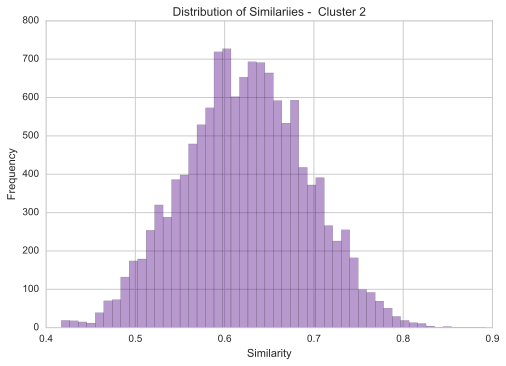

In [175]:
#rec_sim0 = [item for sublist in rec_sim0 for item in sublist]
ax = sns.distplot(rec_sim0,kde=False,color='indigo')
ax.set(xlabel='Similarity', ylabel='Frequency')
ax.set_title("Distribution of Similariies -  Cluster 2")


In [170]:
#Distribution of Similarity scores for Cluster 1
user_cluster_n = users_clustered3[users_clustered3.cluster_num == 1]
rec_sim1 = []
for i in user_cluster_n['userId']:
    rec_sim1.append(sim_make_rec(user_cluster_n,1,users,job_pcs20,jobs,users_data,i))

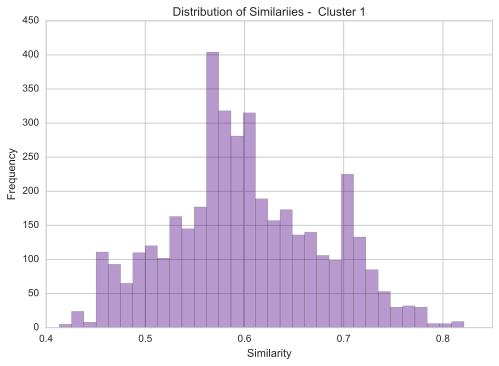

In [174]:
#rec_sim1 = [item for sublist in rec_sim1 for item in sublist]
ax = sns.distplot(rec_sim1,kde=False,color='indigo')
ax.set(xlabel='Similarity', ylabel='Frequency')
ax.set_title("Distribution of Similariies -  Cluster 1")


In [169]:
#Distribution of Similarity scores for Cluster 2
user_cluster_n = users_clustered3[users_clustered3.cluster_num == 2]
rec_sim2 = []
for i in user_cluster_n['userId']:
    rec_sim2.append(sim_make_rec(user_cluster_n,2,users,job_pcs20,jobs,users_data,i))

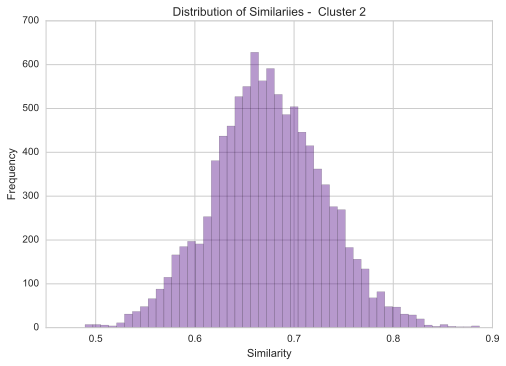

In [172]:
#rec_sim2 = [item for sublist in rec_sim2 for item in sublist]
ax = sns.distplot(rec_sim2,kde=False,color='indigo')
ax.set(xlabel='Similarity', ylabel='Frequency')
ax.set_title("Distribution of Similariies -  Cluster 2")



# Conclusion 

## Modeling

- There is matching between users and jobs based on skills which occur together. Even if there are no skills in common, a user is recommended a job with skills closest to their skill set.
- Data science and Software Engineering have a lot of overlap in skills. 
- The Data science field is relatively ambiguous in terms of skill set . Some Data science jobs require a software engineering element to the skills list where as some require skills pertaining to business intelligence.  
- Software Engineering jobs are more well defined and particular in terms of skill sets. 
    For example, Mobile development require iOS, Android skills for the most part where as a full stack engineer don't have. The skills and responsibilities have more structure in software engineering based job descriptions.

## Processing Job Descriptions

- When scraping job descriptions from a job board, most job postings are not hosted by the same content management system. This causes difficulty in understanding the structure of a job description, often times resulting in scraping the entire HTML code for a job posting.
- Beware of javascript tags embedded in HTML code. 
- One of the most difficult tasks was processing a job description to  narrow down on relevant text. Often job descriptions have other text which are associated with gender, race and such disclaimers. 
- Being wary of terms during skill extraction. Some skills such as "aws" , "R", "C" would be turned on in your skill vector when words like "l__aws__" , "__C__ommunication" are present.



## Next Steps 
- Fine tune the parameters in the recommendation engine such as decreasing the number of Principal components
- Validate model with ground truth data set
- Integrate with Github data and build stronger profile for users

In [217]:
user15_all_rec = make_rec(users_clustered3,2,users,job_pcs20,jobs,users_data,3)

In [196]:
users_clustered3[users_clustered3.cluster_num == 2]

userId  Unnamed: 0                                            AboutMe  \
1           1           1  long time ago found xss vuln took entire site ...   
3           3           3  full stack developer stack overflow working ma...   
5           5           5  senior software engineer fresh consulting see ...   
6           6           6           dotnet programmer day cocoa novice night   
7           7           7    president fog creek software inc ceo trello inc   
8           8           8  building cool stuff great teams engineering di...   
12         12          12  web developer working uk developing web applic...   
15         15          15  spare time working software developer contribu...   
24         24          24                                          like code   
29         29          29  email matt mattmitchell com au also keep techn...   
40         40          40                         bowler programming problem   
44         44          44  started professional developer using delphi or...   
48         48          48                 software programmer living vermont   
49         49          49              cto loop llc ericzbeard yahoo dot com   
51         51          51  risk od imagination like friend chauncey wonde...   
52         52          52  uk based net developer gadget freak tweets rep...   
56         56          56  argentina graduated itba software engineer mar...   
57         57          57  manager software development boston see also t...   
59         59          59             oo vb c# learning sharepoint developer   
60         60          60  enjoy running data processing boxes 5 minute l...   
61         61          61  engineer living seattle programming 15 years s...   
62         62          62  web developer using mainly microsoft technolog...   
64         64          64                net developer ottawa ontario canada   
68         68          68  keith henry software development manager runni...   
69         69          69  consultant specializing node js javascript rel...   
74         74          74                         currently blank click edit   
76         76          76                                       geek wannabe   
77         77          77                                               find   
80         80          80  c# net developer london brighton uk think chee...   
81         81          81  high energy programmer problem solver entrepre...   
...       ...         ...                                                ...   
21563   21563       21563  novice programmer keen learning new things sta...   
21590   21590       21590      comes gain knowledge stay hungry stay foolish   
21592   21592       21592                              steps success started   
21600   21600       21600                                            nothing   
21607   21607       21607                                  simple programmer   
21614   21614       21614  c#, class, struct sql server, locking wpf, dat...   
21623   21623       21623  student interactive multimedia design imd thom...   
21624   21624       21624  work mostly front end web development main are...   
21625   21625       21625  areas interest c# html asp net mvc web api web...   
21627   21627       21627  software engineer currently working uk based c...   
21630   21630       21630  net developer builds custom web applications b...   
21637   21637       21637  industrial engineer student interested amateur...   
21642   21642       21642                           c# programmer learn help   
21643   21643       21643                                               nope   
21645   21645       21645          design looks like feels like design works   
21646   21646       21646  software developer specializes net framework c...   
21677   21677       21677                                starter programming   
21681   21681       21681  spare time php developer work net developer de...   
21696  

In [218]:
user15_all_rec

AboutMe  \
1   full stack developer stack overflow working ma...   
5   full stack developer stack overflow working ma...   
6   full stack developer stack overflow working ma...   
9   full stack developer stack overflow working ma...   
11  full stack developer stack overflow working ma...   

                                          title  \
1   Big Data Infrastructure Engineer (m/f) C868   
5                   Principal Software Engineer   
6                   Sr. Software Engineer - API   
9            Java Developer, Electronic Trading   
11                    Full Stack Java Developer   

                                           all_skills  \
1   [control, debugging, 3.5, msbuild, firefox, sv...   
5   [control, debugging, 3.5, msbuild, firefox, sv...   
6   [control, debugging, 3.5, msbuild, firefox, sv...   
9   [control, debugging, 3.5, msbuild, firefox, sv...   
11  [control, debugging, 3.5, msbuild, firefox, sv...   

                                               skills  Reputation  similarity  \
1   [rest api, git, java, database, data science, ...     95009.0    0.741921   
5   [chef, c, git, java, nosql, scala, python, jav...     95009.0    0.700125   
6   [c, java, scala, python, agile, excel, c#, tes...     95009.0    0.691711   
9              [c, git, java, scala, sql, c++, linux]     95009.0    0.676033   
11  [git, java, database, spring, javascript, scal...     95009.0    0.674209   

                     common_skill  
1              {sql, java, linux}  
5   {java, javascript, ruby, sql}  
6           {c#, java, php, ruby}  
9              {sql, java, linux}  
11      {javascript, java, linux}

In [216]:
user15_all_rec.all_skills[2]

['control',
 'debugging',
 '3.5',
 'msbuild',
 'firefox',
 'svn',
 'osx',
 'linux',
 'dynamic',
 'active',
 'google',
 'orm',
 'roslyn',
 'touch',
 'primes',
 'cil',
 'xml',
 'web',
 'ntlm',
 'management',
 'java',
 'iis',
 'wsp',
 'asp.net',
 'tsql',
 'deployment',
 'sharepoint',
 '3',
 'nant',
 'authentication',
 'version',
 'codeplex',
 'iphone',
 '2003',
 'algorithm',
 'multithreading',
 'config',
 '2010',
 'routing',
 'node',
 'core',
 '7',
 'cryptography',
 'c#',
 'timeline',
 'ipod',
 'javascript',
 'js',
 'directory',
 'visual',
 'construction',
 'studio',
 'user',
 'sql',
 'services',
 'php',
 'ruby',
 'tfs',
 'compiler',
 'jquery',
 'language',
 'exception',
 'handling',
 'reflection',
 'metro',
 'windows',
 'mono',
 'assemblies',
 '.net',
 'server',
 'chrome',
 'mvc',
 'svnignore',
 'architecture',
 '2005',
 'release',
 'runtime',
 'interface',
 'microsoft',
 'scripting']

In [215]:
jobs.skills[2]

"['test']"